In [4]:
import os

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils, datasets

sns.set(font_scale=1.4, style="whitegrid")

In [17]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device

device(type='cuda')

In [6]:
torch.cuda.is_available

<function torch.cuda.is_available() -> bool>

In [7]:
classes = ("plane", "car", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck")

def get_dataloaders(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset = datasets.CIFAR10(root="./data", train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testset = datasets.CIFAR10(root="./data", train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

In [13]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm(train_dl):
            
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for xb, yb in tqdm(valid_dl):
                
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [14]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

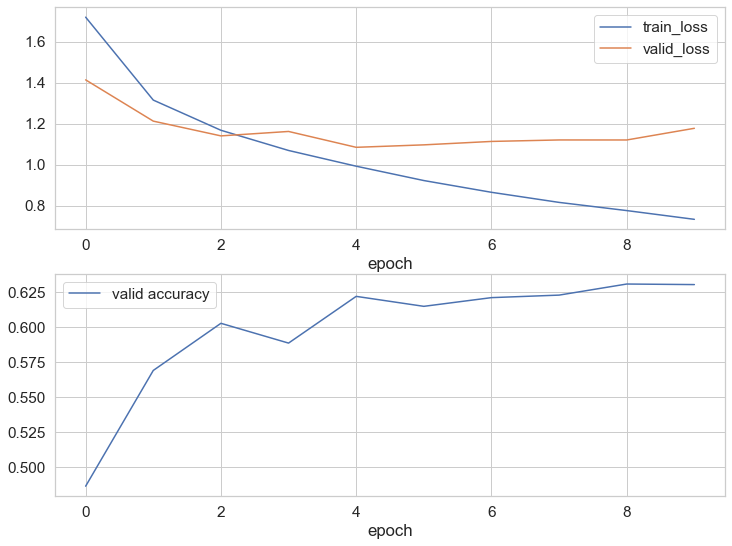

In [16]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)

# BatchNorm

In [18]:
class ModelBatchNorm(nn.Module):
    def __init__(self):
        super(ModelBatchNorm, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = self.bn3(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

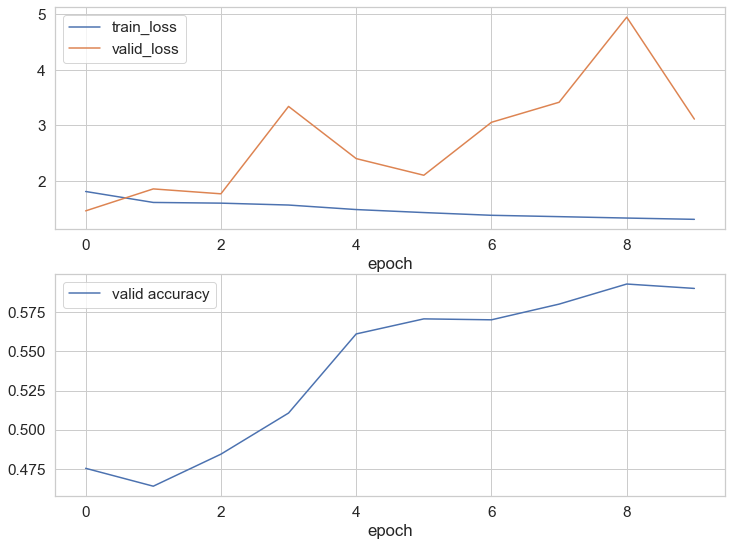

In [19]:
model = ModelBatchNorm()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)

# Dropout

In [20]:
class ModelDropout(nn.Module):
    def __init__(self):
        super(ModelDropout, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

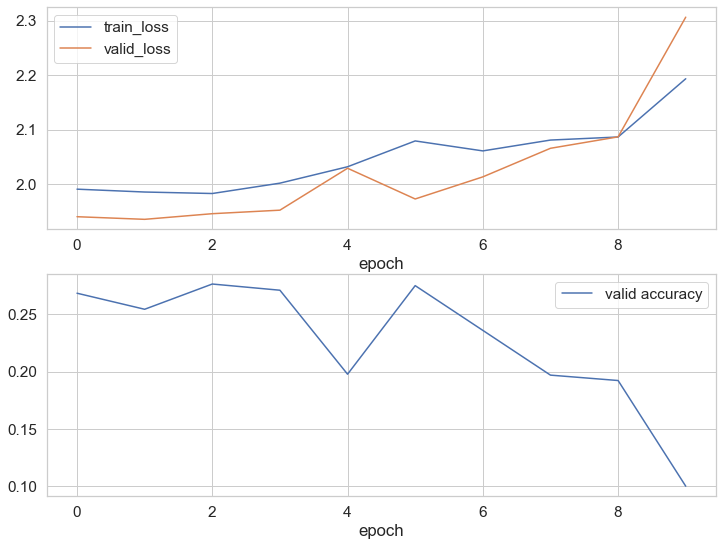

In [22]:
model = ModelDropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=0.5)

info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)